In [51]:
# pip install joblib tqdm 

import json, re, random
from pathlib import Path
from typing import Optional, Iterator, Dict, List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import joblib
from IPython.display import display

from sklearn.model_selection import GroupShuffleSplit, StratifiedGroupKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer, TfidfTransformer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, make_scorer

from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier, PassiveAggressiveClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import ComplementNB
from collections import Counter

In [52]:
DATA_PATH   = Path(r"yelp_academic_dataset_review.json")  
OUT_DIR     = Path("artifacts") # models and outputs are saved here                            
LABEL_SCHEME = "ternary"  # to allow for 3 tiers of reviews, pos = Positive, neg = Negative, neu = Neutral
MAX_ROWS    = 200_000     # capping at 200,000 rows as orignal dataset size is large 
TEST_SIZE   = 0.15
VAL_SIZE    = 0.15
RANDOM_SEED = 42
CV_SPLITS   = 3           # grouped cross validation (on train+val)

np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
OUT_DIR.mkdir(parents=True, exist_ok=True)

In [53]:
# streams yelp reviews from a JSON file (one JSON object per line)
# skips malformed lines

def stream_reviews(jsonl_path: Path, max_rows: Optional[int] = None) -> Iterator[Dict]:
    with jsonl_path.open("r", encoding="utf-8") as f:
        for i, line in enumerate(f):
            if max_rows is not None and i >= max_rows:
                break
            line = line.strip().rstrip(",")
            if not line:
                continue
            try:
                obj = json.loads(line)
            except json.JSONDecodeError:
                continue
            yield obj

def normalize_text(s: str) -> str:
    s = s.replace("\n", " ").strip()
    s = re.sub(r"\s+", " ", s)
    return s

# map star ratings to sentiment labels: ternary: 1–2 → 'neg', 3 → 'neu', 4–5 → 'pos'
def stars_to_sentiment(stars: int, scheme: str = "ternary") -> Optional[str]:
    if stars in (1, 2): return "neg"
    if stars == 3: return "neu"
    if stars in (4, 5): return "pos"
    return None

def load_dataframe(jsonl_path: Path, max_rows: Optional[int], label_scheme: str) -> pd.DataFrame:
    rows = []
    for obj in tqdm(stream_reviews(jsonl_path, max_rows=max_rows), desc="Loading"):
        text = obj.get("text", "")
        stars = obj.get("stars", None)
        bid   = obj.get("business_id", None)
        uid   = obj.get("user_id", None)
        if text is None or stars is None or bid is None:
            continue
        text = normalize_text(text)
        if not text:
            continue
        y = stars_to_sentiment(int(stars), label_scheme)
        if y is None:
            continue
        rows.append({
            "text": text,
            "stars": int(stars),
            "label": y,
            "business_id": bid,
            "user_id": uid
        })
    df = pd.DataFrame(rows)
    df = df.reset_index(drop=True)
    return df

In [54]:
# Disjoint splits by group (business_id) to avoid leakage. First split off test, then split remaining into train/val.

def grouped_train_val_test_split(
    df: pd.DataFrame,
    group_col: str = "business_id",
    label_col: str = "label",
    test_size: float = 0.15,
    val_size: float = 0.15,
    random_state: int = 42
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:

    idx = np.arange(len(df))
    groups = df[group_col].values
    y = df[label_col].values

    gss1 = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    train_val_idx, test_idx = next(gss1.split(idx, y, groups))

    gss2 = GroupShuffleSplit(n_splits=1, test_size=val_size / (1 - test_size), random_state=random_state)
    train_idx, val_idx = next(gss2.split(train_val_idx, y[train_val_idx], groups[train_val_idx]))

    return train_val_idx[train_idx], train_val_idx[val_idx], test_idx

In [55]:
# building the model pipelines for TfidVectorizer: transforms text to feature vectors that can be used as input to estimator and
# LogisticRegression: statistical model that models the log-odds of an event as a linear combination of one or more independent variables

def build_pipeline() -> Pipeline:
    return Pipeline([
        ("tfidf", TfidfVectorizer(
            lowercase=True,
            stop_words="english",
            ngram_range=(1, 1),     
            min_df=10,              
            max_df=0.9,
            max_features=200_000,   # add a cap for features
            strip_accents="unicode",
            dtype=np.float32        
        )),
        ("clf", LogisticRegression(
            max_iter=1000,          
            tol=1e-3,               # looser tolerance
            class_weight="balanced",
            solver="saga",
            n_jobs=-1,
            C=1.0,
            random_state=RANDOM_SEED
        ))
    ])

In [56]:
print(f"Reading: {DATA_PATH} (max_rows={MAX_ROWS})")
df = load_dataframe(DATA_PATH, max_rows=MAX_ROWS, label_scheme=LABEL_SCHEME)

print("\nLabel distribution:")
print(df["label"].value_counts())

tr_idx, va_idx, te_idx = grouped_train_val_test_split(
    df, group_col="business_id", label_col="label",
    test_size=TEST_SIZE, val_size=VAL_SIZE, random_state=RANDOM_SEED
)

X_train = df.loc[tr_idx, "text"].tolist()
y_train = df.loc[tr_idx, "label"].tolist()
X_val   = df.loc[va_idx, "text"].tolist()
y_val   = df.loc[va_idx, "label"].tolist()
X_test  = df.loc[te_idx, "text"].tolist()
y_test  = df.loc[te_idx, "label"].tolist()

print(f"\nSizes — train: {len(X_train)} | val: {len(X_val)} | test: {len(X_test)}")

Reading: yelp_academic_dataset_review.json (max_rows=200000)


Loading: 200000it [00:05, 36704.58it/s]



Label distribution:
label
pos    139314
neg     38038
neu     22648
Name: count, dtype: int64

Sizes — train: 142937 | val: 27298 | test: 29765


In [57]:
pipe = build_pipeline()

def grouped_cv_scores(pipe: Pipeline, X: List[str], y: List[str], groups: List[str], n_splits: int = 3):
    sgkf = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)
    accs, f1s = [], []
    for tr, va in sgkf.split(X, y, groups=groups):
        pipe.fit([X[i] for i in tr], [y[i] for i in tr])
        yp = pipe.predict([X[i] for i in va])
        accs.append(accuracy_score([y[i] for i in va], yp))
        f1s.append(f1_score([y[i] for i in va], yp, average="macro"))
    return np.mean(accs), np.mean(f1s)

print("\nRunning grouped CV (train+val)…")
X_trva = df.loc[np.r_[tr_idx, va_idx], "text"].tolist()
y_trva = df.loc[np.r_[tr_idx, va_idx], "label"].tolist()
g_trva = df.loc[np.r_[tr_idx, va_idx], "business_id"].tolist()
cv_acc, cv_f1 = grouped_cv_scores(pipe, X_trva, y_trva, g_trva, n_splits=CV_SPLITS)
print(f"CV Accuracy: {cv_acc:.4f} | CV Macro-F1: {cv_f1:.4f}")

print("\nFitting on train…")
pipe.fit(X_train, y_train)

print("Validation metrics:")
y_val_pred = pipe.predict(X_val)
print(classification_report(y_val, y_val_pred, digits=4))
print("Confusion matrix (val):\n", confusion_matrix(y_val, y_val_pred))

print("\nRefitting on train+val…")
pipe.fit(X_trva, y_trva)

print("Test metrics:")
y_test_pred = pipe.predict(X_test)
print(classification_report(y_test, y_test_pred, digits=4))
print("Confusion matrix (test):\n", confusion_matrix(y_test, y_test_pred))
print(f"TEST Accuracy: {accuracy_score(y_test, y_test_pred):.4f} | TEST Macro-F1: {f1_score(y_test, y_test_pred, average='macro'):.4f}")


Running grouped CV (train+val)…


C:\Users\ruthw\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ruthw\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ruthw\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


CV Accuracy: 0.8099 | CV Macro-F1: 0.6978

Fitting on train…


C:\Users\ruthw\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Validation metrics:
              precision    recall  f1-score   support

         neg     0.7609    0.8235    0.7910      5456
         neu     0.3431    0.5214    0.4139      3057
         pos     0.9454    0.8429    0.8912     18785

    accuracy                         0.8030     27298
   macro avg     0.6831    0.7293    0.6987     27298
weighted avg     0.8411    0.8030    0.8177     27298

Confusion matrix (val):
 [[ 4493   784   179]
 [  728  1594   735]
 [  684  2268 15833]]

Refitting on train+val…


C:\Users\ruthw\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Test metrics:
              precision    recall  f1-score   support

         neg     0.8064    0.7618    0.7835      5857
         neu     0.3270    0.6165    0.4273      3356
         pos     0.9506    0.8281    0.8851     20552

    accuracy                         0.7912     29765
   macro avg     0.6947    0.7355    0.6986     29765
weighted avg     0.8519    0.7912    0.8135     29765

Confusion matrix (test):
 [[ 4462  1197   198]
 [  600  2069   687]
 [  471  3062 17019]]
TEST Accuracy: 0.7912 | TEST Macro-F1: 0.6986


In [58]:
# save the models

model_path = OUT_DIR / f"yelp_sentiment_{LABEL_SCHEME}.joblib"
joblib.dump(pipe, model_path)
with (OUT_DIR / f"meta_{LABEL_SCHEME}.json").open("w", encoding="utf-8") as f:
    json.dump({"label_scheme": LABEL_SCHEME}, f, indent=2)
print(f"\nSaved model to: {model_path}")


Saved model to: artifacts\yelp_sentiment_ternary.joblib


In [59]:
def infer_label_order(y_true, y_pred):
    labels = sorted(set(y_true) | set(y_pred))
    if {"neg","neu","pos"}.issubset(labels):
        return ["neg","neu","pos"]
    return labels

def plot_confusion(y_true, y_pred, labels=None, normalize=False, title="Confusion matrix", savepath=None):
    if labels is None:
        labels = infer_label_order(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=labels,
                          normalize=("true" if normalize else None))
    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(cm, interpolation="nearest")
    ax.figure.colorbar(im, ax=ax)
    ax.set(
        xticks=np.arange(len(labels)),
        yticks=np.arange(len(labels)),
        xticklabels=labels,
        yticklabels=labels,
        ylabel="True label",
        xlabel="Predicted label",
        title=title + (" (normalized)" if normalize else "")
    )
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    fmt = ".2f" if normalize else "d"
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center")
    plt.tight_layout()
    if savepath:
        fig.savefig(savepath, dpi=150, bbox_inches="tight")
    plt.show()
    return cm

def report_dataframe(y_true, y_pred, labels=None, title="Classification report"):
    rep = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    df = pd.DataFrame(rep).T
    if labels is None:
        labels = infer_label_order(y_true, y_pred)
    core_rows = labels + ["accuracy", "macro avg", "weighted avg"]
    df = df.reindex([r for r in core_rows if r in df.index])
    df = df.rename(columns={"precision":"Precision","recall":"Recall","f1-score":"F1","support":"Support"})
    df["Support"] = df["Support"].astype(int)
    df = df.round({"Precision":4,"Recall":4,"F1":4})
    print(f"\n{title}")
    try:
        display(df)  
    except:
        print(df.to_string())
    return df 

def plot_metric_bars(report_df, metric="F1", title="Per-class F1", savepath=None):
    exclude = {"accuracy","macro avg","weighted avg"}
    cls_df = report_df[~report_df.index.isin(exclude)]
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.bar(cls_df.index.astype(str), cls_df[metric].values)
    ax.set_ylim(0, 1)
    ax.set_ylabel(metric)
    ax.set_xlabel("Class")
    ax.set_title(title)
    plt.tight_layout()
    if savepath:
        fig.savefig(savepath, dpi=150, bbox_inches="tight")
    plt.show()

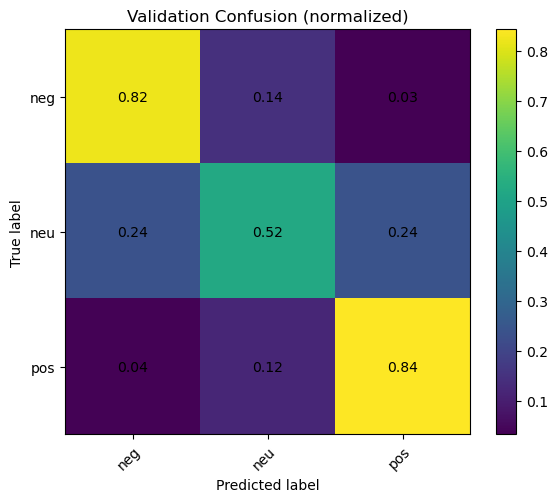


Validation Classification Report


,Precision,Recall,F1,Support
neg,0.7609,0.8235,0.7910,5456
neu,0.3431,0.5214,0.4139,3057
pos,0.9454,0.8429,0.8912,18785
accuracy,0.8030,0.8030,0.8030,0
macro avg,0.6831,0.7293,0.6987,27298
weighted avg,0.8411,0.8030,0.8177,27298


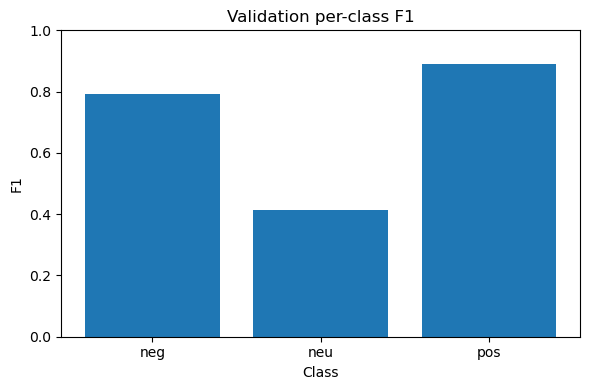

In [60]:
# validation visuals

labels = infer_label_order(y_val, y_val_pred)

plot_confusion(y_val, y_val_pred, labels=labels, normalize=True,  title="Validation Confusion")

val_report_df = report_dataframe(y_val, y_val_pred, labels=labels, title="Validation Classification Report")
plot_metric_bars(val_report_df, metric="F1", title="Validation per-class F1")

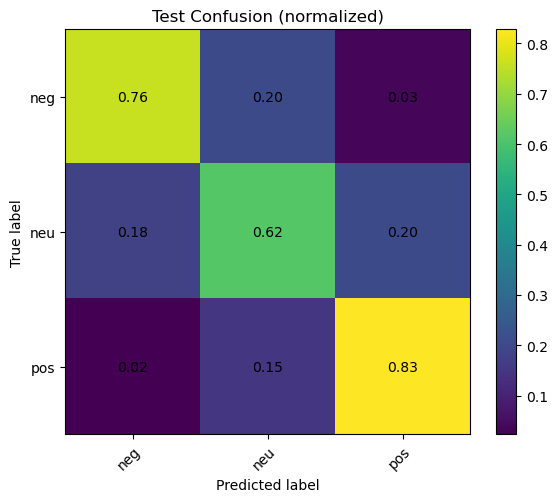


Test Classification Report


,Precision,Recall,F1,Support
neg,0.8064,0.7618,0.7835,5857
neu,0.3270,0.6165,0.4273,3356
pos,0.9506,0.8281,0.8851,20552
accuracy,0.7912,0.7912,0.7912,0
macro avg,0.6947,0.7355,0.6986,29765
weighted avg,0.8519,0.7912,0.8135,29765


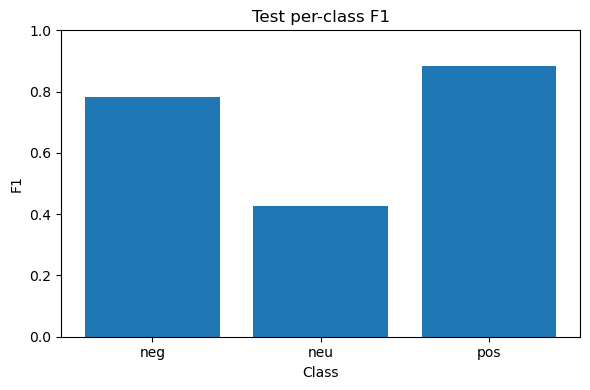

In [61]:
# test visuals

labels_test = infer_label_order(y_test, y_test_pred) 
plot_confusion(y_test, y_test_pred, labels=labels_test, normalize=True,  title="Test Confusion")

test_report_df = report_dataframe(y_test, y_test_pred, labels=labels_test, title="Test Classification Report")
plot_metric_bars(test_report_df, metric="F1", title="Test per-class F1")

In [12]:
# quick summary

print(f"\nTEST Accuracy: {accuracy_score(y_test, y_test_pred):.4f} | "
      f"TEST Macro-F1: {f1_score(y_test, y_test_pred, average='macro'):.4f}")


TEST Accuracy: 0.7912 | TEST Macro-F1: 0.6986


In [13]:
def build_models(random_state=RANDOM_SEED):
    tfidf_cfg = dict(
        lowercase=True, stop_words="english", ngram_range=(1,1),
        min_df=10, max_df=0.9, max_features=200_000,
        strip_accents="unicode", dtype=np.float32
    )
    count_cfg = dict(  # for NB (works best with counts)
        lowercase=True, stop_words="english", ngram_range=(1,1),
        min_df=10, max_df=0.9, strip_accents="unicode"
    )

    models = {
        "logreg": Pipeline([
            ("tfidf", TfidfVectorizer(**tfidf_cfg)),
            ("clf", LogisticRegression(
                max_iter=1000, tol=1e-3, C=1.0,
                solver="saga", class_weight="balanced",
                n_jobs=-1, random_state=random_state
            ))
        ]),
        "linsvc": Pipeline([
            ("tfidf", TfidfVectorizer(**tfidf_cfg)),
            ("clf", LinearSVC(C=1.0, class_weight="balanced", random_state=random_state))
        ]),
        "sgd": Pipeline([
            ("tfidf", TfidfVectorizer(**tfidf_cfg)),
            ("clf", SGDClassifier(
                loss="modified_huber", alpha=1e-4,
                max_iter=1000, tol=1e-3, random_state=random_state
            ))
        ]),
        "ridge": Pipeline([
            ("tfidf", TfidfVectorizer(**tfidf_cfg)),
            ("clf", RidgeClassifier(alpha=1.0, class_weight="balanced"))
        ]),
        "compNB": Pipeline([
            ("count", CountVectorizer(**count_cfg)),
            ("clf", ComplementNB(alpha=0.5))
        ]),
    }
    return models

In [14]:
def compare_on_val(models, X_tr, y_tr, X_val, y_val):
    rows = []
    fitted = {}
    for name, pipe in models.items():
        print(f"\nTraining {name} …")
        pipe.fit(X_tr, y_tr)
        pred = pipe.predict(X_val)
        acc = accuracy_score(y_val, pred)
        f1  = f1_score(y_val, pred, average="macro")
        rows.append({"model": name, "val_acc": acc, "val_macro_f1": f1})
        print(f"{name} | val_acc={acc:.4f} | val_macro_f1={f1:.4f}")
        fitted[name] = pipe
    df = pd.DataFrame(rows).sort_values("val_macro_f1", ascending=False)
    print("\n--- Validation leaderboard (sorted by val_macro_f1) ---")
    print(df.to_string(index=False))
    return df, fitted

In [15]:
models = build_models()
val_results, fitted_models = compare_on_val(models, X_train, y_train, X_val, y_val)


Training logreg …


C:\Users\ruthw\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


logreg | val_acc=0.8030 | val_macro_f1=0.6987

Training linsvc …
linsvc | val_acc=0.8254 | val_macro_f1=0.6918

Training sgd …
sgd | val_acc=0.8486 | val_macro_f1=0.6466

Training ridge …
ridge | val_acc=0.7809 | val_macro_f1=0.6758

Training compNB …
compNB | val_acc=0.8008 | val_macro_f1=0.6035

--- Validation leaderboard (sorted by val_macro_f1) ---
 model  val_acc  val_macro_f1
logreg 0.802989      0.698671
linsvc 0.825408      0.691798
 ridge 0.780936      0.675777
   sgd 0.848634      0.646570
compNB 0.800828      0.603491


In [63]:
PRIMARY   = "val_macro_f1"   
SECONDARY = "val_acc"        # tie breaker to decide best model during comparisons

vr = val_results.copy()
for col in [PRIMARY, SECONDARY]:
    vr[col] = pd.to_numeric(vr[col], errors="coerce")

# sort by PRIMARY then SECONDARY, both descending
vr = vr.sort_values([PRIMARY, SECONDARY], ascending=False, kind="mergesort").reset_index(drop=True)

print("\n--- Sorted leaderboard ---")
print(vr.to_string(index=False))

best_name = vr.loc[0, "model"]              
best_pipe = fitted_models[best_name]
print(f"\nBest on {PRIMARY} → {SECONDARY}: {best_name}")


--- Sorted leaderboard ---
 model  val_acc  val_macro_f1
logreg 0.802989      0.698671
linsvc 0.825408      0.691798
 ridge 0.780936      0.675777
   sgd 0.848634      0.646570
compNB 0.800828      0.603491

Best on val_macro_f1 → val_acc: logreg


In [48]:
# detailed report for the best model on validation

y_val_pred = best_pipe.predict(X_val)
print(f"\nValidation report for {best_name}:")
print(classification_report(y_val, y_val_pred, digits=4))
print("Confusion matrix (val):\n", confusion_matrix(y_val, y_val_pred))


Validation report for logreg:
              precision    recall  f1-score   support

         neg     0.8623    0.8264    0.8440      5456
         neu     0.4170    0.7789    0.5432      3057
         pos     0.9710    0.8456    0.9039     18785

    accuracy                         0.8343     27298
   macro avg     0.7501    0.8170    0.7637     27298
weighted avg     0.8872    0.8343    0.8516     27298

Confusion matrix (val):
 [[ 4509   827   120]
 [  321  2381   355]
 [  399  2502 15884]]


In [49]:
# refit the best model on train+val, then test

X_trva = df.loc[np.r_[tr_idx, va_idx], "text"].tolist()
y_trva = df.loc[np.r_[tr_idx, va_idx], "label"].tolist()
print("\nRe-fitting best model on train+val …")
best_pipe.fit(X_trva, y_trva)
y_test_pred = best_pipe.predict(X_test)
print("\nTest report (best model):")
print(classification_report(y_test, y_test_pred, digits=4))
print("Confusion matrix (test):\n", confusion_matrix(y_test, y_test_pred))


Re-fitting best model on train+val …


C:\Users\ruthw\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



Test report (best model):
              precision    recall  f1-score   support

         neg     0.8064    0.7618    0.7835      5857
         neu     0.3270    0.6165    0.4273      3356
         pos     0.9506    0.8281    0.8851     20552

    accuracy                         0.7912     29765
   macro avg     0.6947    0.7355    0.6986     29765
weighted avg     0.8519    0.7912    0.8135     29765

Confusion matrix (test):
 [[ 4462  1197   198]
 [  600  2069   687]
 [  471  3062 17019]]


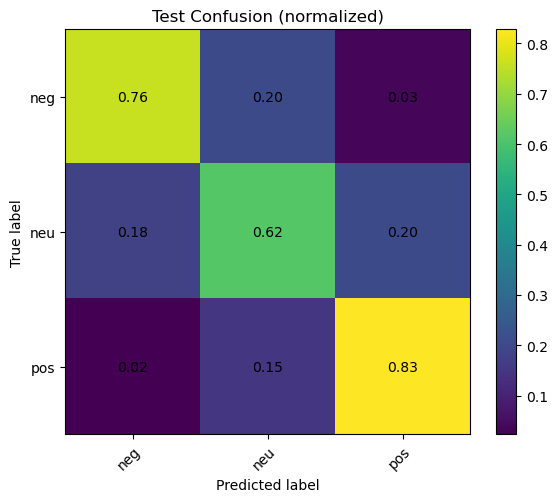

array([[0.76182346, 0.20437084, 0.0338057 ],
       [0.17878427, 0.61650775, 0.20470799],
       [0.02291748, 0.14898793, 0.82809459]])

In [50]:
plot_confusion(y_test, y_test_pred, labels=labels_test, normalize=True,  title="Confusion Matrix for logreg")

In [29]:
### EDA

def stream_reviews(jsonl_path: Path, max_rows=None):
    with jsonl_path.open("r", encoding="utf-8") as f:
        for i, line in enumerate(f):
            if max_rows is not None and i >= max_rows:
                break
            line = line.strip().rstrip(",")
            if not line:
                continue
            try:
                obj = json.loads(line)
            except json.JSONDecodeError:
                continue
            yield obj

def normalize_text(s: str) -> str:
    s = s.replace("\n", " ").strip()
    s = re.sub(r"\s+", " ", s)
    return s

def load_dataframe(jsonl_path: Path, max_rows=None) -> pd.DataFrame:
    rows = []
    for obj in tqdm(stream_reviews(jsonl_path, max_rows), desc="Loading"):
        text = obj.get("text", "")
        if text is None: 
            continue
        rows.append({
            "review_id": obj.get("review_id"),
            "user_id": obj.get("user_id"),
            "business_id": obj.get("business_id"),
            "stars": obj.get("stars"),
            "date": obj.get("date"),
            "useful": obj.get("useful", 0),
            "funny": obj.get("funny", 0),
            "cool": obj.get("cool", 0),
            "text": normalize_text(text)
        })
    df = pd.DataFrame(rows)
    # Coerce types
    df["stars"] = pd.to_numeric(df["stars"], errors="coerce").astype("Int64")
    df["date"]  = pd.to_datetime(df["date"], errors="coerce")
    return df.dropna(subset=["text", "stars"]).reset_index(drop=True)

print(f"Reading: {DATA_PATH} (max_rows={MAX_ROWS})")
datafr = load_dataframe(DATA_PATH, MAX_ROWS)

Reading: yelp_academic_dataset_review.json (max_rows=200000)


Loading: 200000it [00:05, 33480.18it/s]


In [30]:
# structure and sanity checks

print(datafr.head(3))
print("\nShape:", datafr.shape)
print("\nMissing by column:\n", datafr.isna().sum())
print("\nStars value counts:\n", datafr["stars"].value_counts().sort_index())

# Basic text length features
datafr["char_len"]  = datafr["text"].str.len()
datafr["word_len"]  = datafr["text"].str.split().str.len()

                review_id                 user_id             business_id  \
0  KU_O5udG6zpxOg-VcAEodg  mh_-eMZ6K5RLWhZyISBhwA  XQfwVwDr-v0ZS3_CbbE5Xw   
1  BiTunyQ73aT9WBnpR9DZGw  OyoGAe7OKpv6SyGZT5g77Q  7ATYjTIgM3jUlt4UM3IypQ   
2  saUsX_uimxRlCVr67Z4Jig  8g_iMtfSiwikVnbP2etR0A  YjUWPpI6HXG530lwP-fb2A   

   stars                date  useful  funny  cool  \
0      3 2018-07-07 22:09:11       0      0     0   
1      5 2012-01-03 15:28:18       1      0     1   
2      3 2014-02-05 20:30:30       0      0     0   

                                                text  
0  If you decide to eat here, just be aware it is...  
1  I've taken a lot of spin classes over the year...  
2  Family diner. Had the buffet. Eclectic assortm...  

Shape: (200000, 9)

Missing by column:
 review_id      0
user_id        0
business_id    0
stars          0
date           0
useful         0
funny          0
cool           0
text           0
dtype: int64

Stars value counts:
 stars
1    21922
2    16116
3

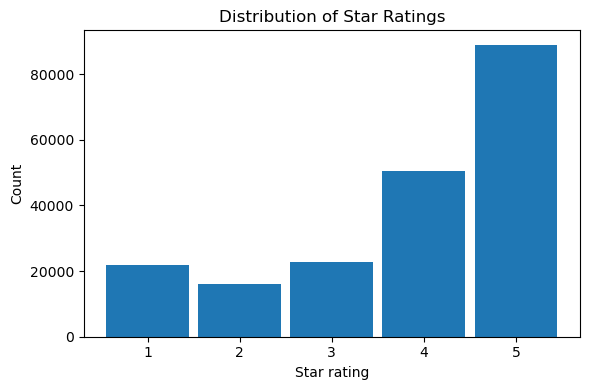

In [31]:
# distributions

plt.figure(figsize=(6,4))
datafr["stars"].astype(int).plot(kind="hist", bins=[0.5,1.5,2.5,3.5,4.5,5.5], rwidth=0.9)
plt.xticks([1,2,3,4,5])
plt.xlabel("Star rating")
plt.ylabel("Count")
plt.title("Distribution of Star Ratings")
plt.tight_layout(); plt.show()

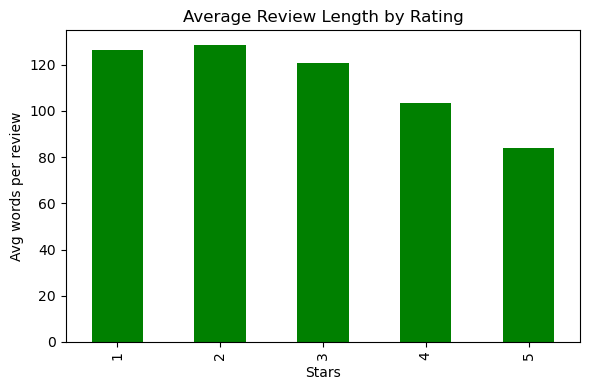


Avg words by star:
 stars
1    126.31
2    128.52
3    120.61
4    103.29
5     84.15
Name: word_len, dtype: float64


In [37]:
avg_len_by_star = df.groupby("stars")["word_len"].mean()
plt.figure(figsize=(6,4))
avg_len_by_star.plot(kind="bar", color="green")
plt.xlabel("Stars")
plt.ylabel("Avg words per review")
plt.title("Average Review Length by Rating")
plt.tight_layout(); plt.show()
print("\nAvg words by star:\n", avg_len_by_star.round(2))

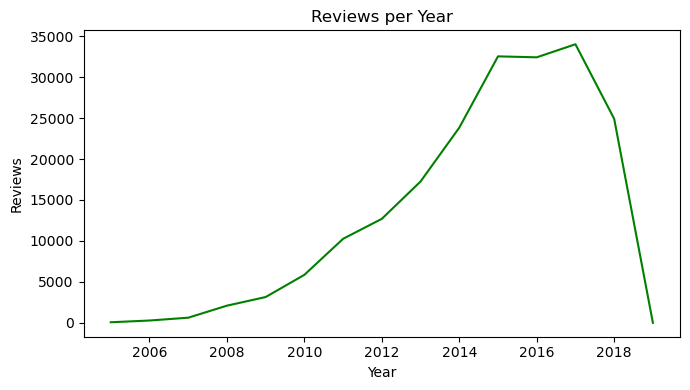

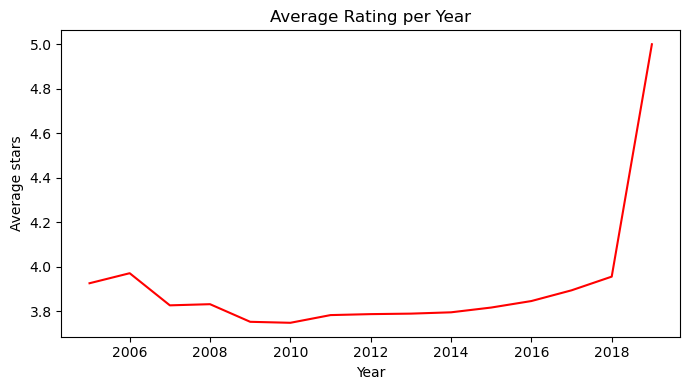

In [38]:
# trends over time

if datafr["date"].notna().any():
    datafr["year"] = datafr["date"].dt.year
    yearly_counts = datafr.groupby("year").size()
    yearly_mean   = datafr.groupby("year")["stars"].mean()

    plt.figure(figsize=(7,4))
    yearly_counts.plot(color="green")
    plt.xlabel("Year"); plt.ylabel("Reviews")
    plt.title("Reviews per Year")
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(7,4))
    yearly_mean.plot(color="red")
    plt.xlabel("Year"); plt.ylabel("Average stars")
    plt.title("Average Rating per Year")
    plt.tight_layout(); plt.show()

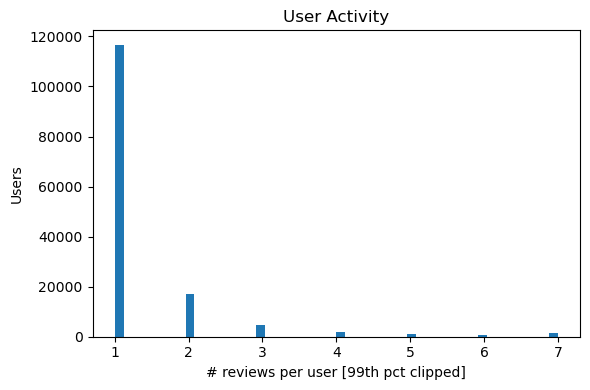

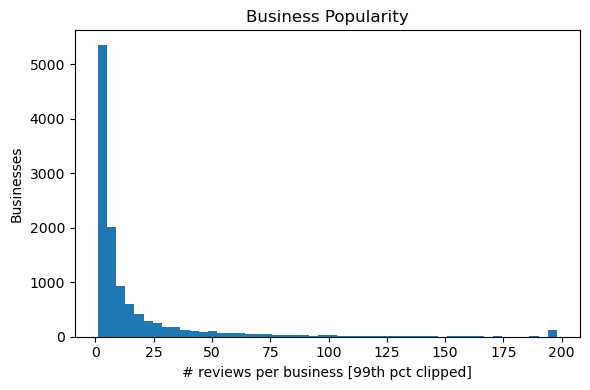

In [40]:
# power users and frequent visited businesses

rev_per_user = datafr.groupby("user_id").size()
rev_per_biz  = datafr.groupby("business_id").size()

plt.figure(figsize=(6,4))
rev_per_user.clip(upper=rev_per_user.quantile(0.99)).plot(kind="hist", bins=50)
plt.xlabel("# reviews per user [99th pct clipped]")
plt.ylabel("Users")
plt.title("User Activity")
plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
rev_per_biz.clip(upper=rev_per_biz.quantile(0.99)).plot(kind="hist", bins=50)
plt.xlabel("# reviews per business [99th pct clipped]")
plt.ylabel("Businesses")
plt.title("Business Popularity")
plt.tight_layout(); plt.show()

In [25]:
# top bag of words for each star rating

def stratified_sample_by_star(df, frac=0.15, random_state=RANDOM_SEED):
    parts = []
    for s, grp in df.groupby("stars"):
        parts.append(grp.sample(frac=min(frac, 1.0), random_state=random_state))
    return pd.concat(parts, ignore_index=True)

df_sample = stratified_sample_by_star(datafr, frac=0.15)

def top_ngrams_by_star(df_sub, ngram_range=(1,2), min_df=50, topk=10):
    vec = CountVectorizer(stop_words="english", ngram_range=ngram_range, min_df=min_df)
    X = vec.fit_transform(df_sub["text"])
    vocab = np.array(vec.get_feature_names_out())

    for star in sorted(df_sub["stars"].unique()):
        mask = (df_sub["stars"] == star).to_numpy() 
        cls = (X[mask].sum(axis=0).A1 + 1)      
        oth = (X[~mask].sum(axis=0).A1 + 1)
        ratio = cls / oth
        top_idx = np.argsort(ratio)[-topk:][::-1]
        print(f"\nTop {topk} n-grams for {star}★ (ratio = P(term|{star}) / P(term|others))")
        for t, r, c in zip(vocab[top_idx], ratio[top_idx], (cls[top_idx]-1)):
            print(f"{t:30s}  ratio={r:6.2f}  count={int(c)}")

top_ngrams_by_star(df_sample, ngram_range=(1,2), min_df=50, topk=10)


Top 10 n-grams for 1★ (ratio = P(term|1) / P(term|others))
refund                          ratio=  3.48  count=86
unprofessional                  ratio=  3.07  count=85
horrible service                ratio=  3.07  count=45
waste time                      ratio=  2.68  count=74
don waste                       ratio=  2.50  count=44
unacceptable                    ratio=  2.44  count=43
refused                         ratio=  2.37  count=82
worst                           ratio=  2.35  count=417
time money                      ratio=  2.29  count=47
apology                         ratio=  1.94  count=67

Top 10 n-grams for 2★ (ratio = P(term|2) / P(term|others))
meh                             ratio=  0.94  count=83
hopes                           ratio=  0.83  count=33
mediocre best                   ratio=  0.81  count=24
downhill                        ratio=  0.78  count=35
silverware                      ratio=  0.74  count=31
won going                       ratio=  0.73  count=23

In [39]:
print("\n5 Longest reviews by words:")
print(df.nlargest(5, "word_len")[["stars","word_len","text"]])

print("\n5 Largest 'useful' reviews:")
print(df.nlargest(5, "useful")[["stars","word_len","text"]])


5 Longest reviews by words:
        stars  word_len                                               text
695         1      1006  Unfortunately, I'm NOT happy after coming to t...
115828      5       990  I have recently moved to Fl and top priority o...
167055      1       983  like many others, i found this place through Y...
143347      3       980  I love Japanese food. I was introduced to sush...
41305       1       979  I hate to do this. I really do. But the experi...

5 Largest 'useful' reviews:
        stars  word_len                                               text
81674       1       123  I would not recommend anyone to live here. The...
64662       1       358  Update 8/9/14: There are now swarms of childre...
7741        5        16  fast service and superb skills. this is by far...
135071      1       629  HUUUUUUUUUUUUGE MISTAKE! I drive by this parti...
144381      2       112  We only went because of the groupon. If you're...
